# BIAFLOWS as image source 

This notebook demonstrates how to download images from the BIAFLOWS server.

##  Connecting to the BIAFLOWS server

Run the cell and enter the public and private key to connect to BIAFLOWS. To find the API-keys, please log-in to BIAFLOWS at: [https://biaflows.neubias.org](https://biaflows.neubias.org). Go to your [account settings](https://biaflows.neubias.org/#/account) to find the keys.

In [2]:
import ipywidgets as widgets
BIAFLOW_SERVERS=["biaflows.neubias.org"]
connectionDialog_title = widgets.HTML(
    value="<h2>Connect to BIAFLOWS</h2>",
)
connectionDialog_menu = widgets.Dropdown(
       options=BIAFLOW_SERVERS,
       value=BIAFLOW_SERVERS[0],
       description='server:')
connectionDialog_publicKey=widgets.Password(description='public key:')
connectionDialog_privateKey=widgets.Password(description='private key:')
connectionDialog = widgets.VBox([connectionDialog_title, connectionDialog_menu, 
                                 connectionDialog_publicKey, connectionDialog_privateKey])
display(connectionDialog)


A connection to BIAFLOWS is created using the API-keys.

In [3]:
import logging
from cytomine import Cytomine
 
host = connectionDialog_menu.value
publicKey = connectionDialog_publicKey.value
privateKey = connectionDialog_privateKey.value
  
with Cytomine(host=host, public_key=publicKey, private_key=privateKey,
              verbose=logging.INFO) as conn:
    print(conn.current_user)

[2020-01-17 17:20:18,619][INFO] [GET] [currentuser] CURRENT USER - 3002336 : guest | 200 OK
[currentuser] CURRENT USER - 3002336 : guest


## Selecting a project

The list of projects is retrieved from the server and displayed in a menu. Please select the project ``Nuclei-Segmentation`` for this demonstration!

In [4]:
from cytomine.models import ProjectCollection
projects = ProjectCollection().fetch()
projectNames = [project.name for project in projects]
projectIDs = [project.id for project in projects]
projectDialog_menu = widgets.Dropdown(
       options=list(zip(projectNames, projectIDs)),
       value=projectIDs[1],
       description='project:')

projectDialog_menu

[2020-01-17 17:20:20,805][INFO] [GET] [project collection] 17 objects | 200 OK


Dropdown(description='project:', index=1, options=(('DEMO-SEGMENTATION-TISSUE', 1438), ('NUCLEI-SEGMENTATION',…

## Downloading the images of the project

The Neubias-utilities are used to download the input and ground-truth images. The images are saved into a folder with ``<job-identifier>/in`` and the ground-truth images into ``<job-identifier>/ground_truth``.

**Remark 1**: The prepare_data function needs a software-id, we use an, arbitrary one among the existing software ids. It will not be used in the follwoing.

In [5]:
%%capture
from neubiaswg5.helpers import NeubiasJob, prepare_data
from cytomine.models import Project

projectID = projectDialog_menu.value
project = Project().fetch(id=projectID)
argv = ['--cytomine_public_key', publicKey, 
 '--cytomine_host',  host,
 '--cytomine_private_key',  privateKey,
 '--cytomine_id_project',  str(projectID), 
 '--cytomine_id_software', '32392501']
with NeubiasJob.from_cli(argv) as nj:
    jobID = nj.job.id
    in_images, gt_images, in_path, gt_path, out_path, tmp_path = prepare_data(project.disciplineShortName, nj, is_2d=True, **nj.flags)

[2020-01-17 17:20:23,533][INFO] [GET] [project] 5955 : NUCLEI-SEGMENTATION | 200 OK


## Displaying the images

The input images are displayed. BIAFLOWS uses tif-images. All images are loaded into memory in this example. 

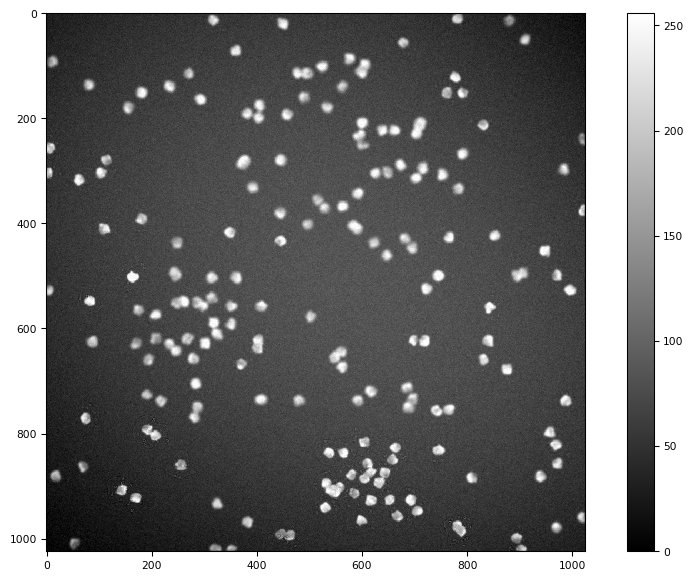

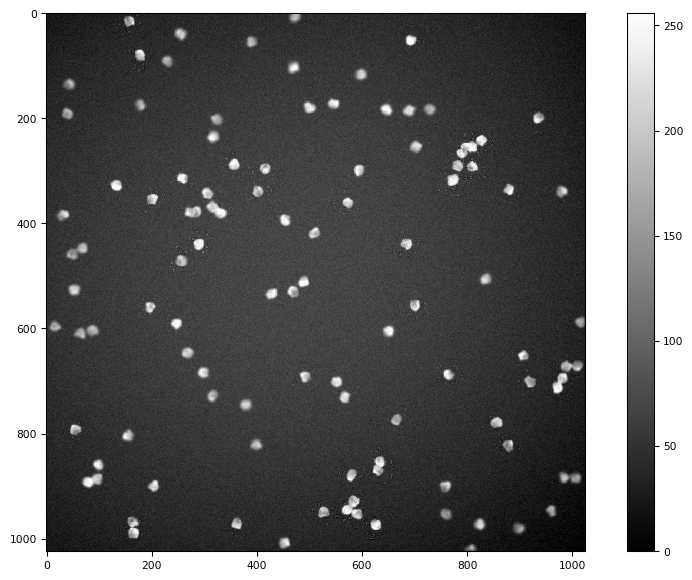

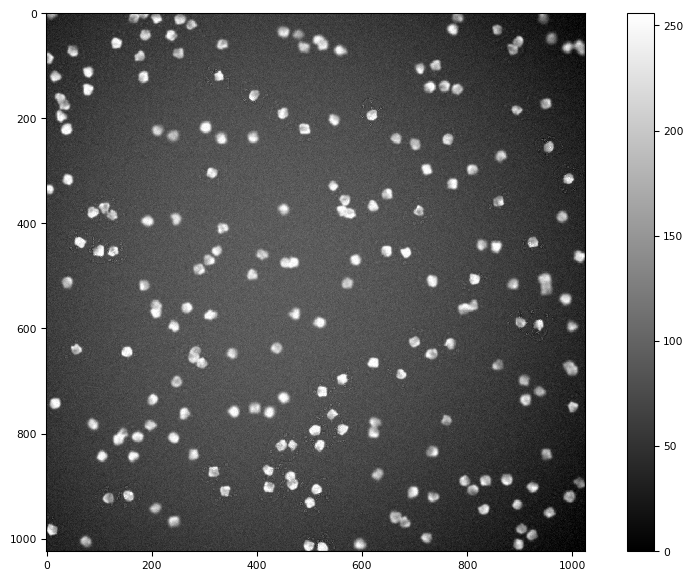

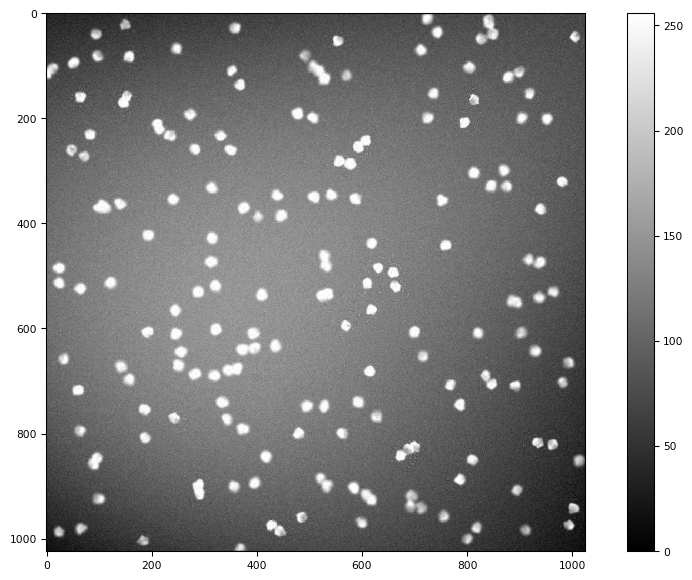

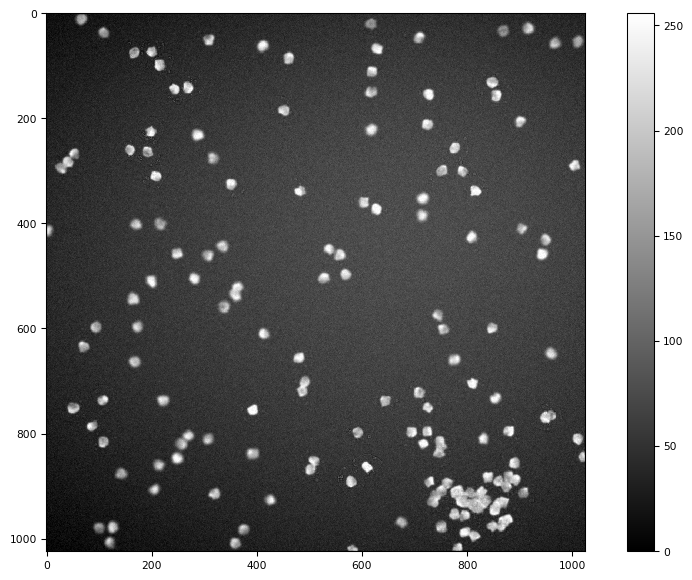

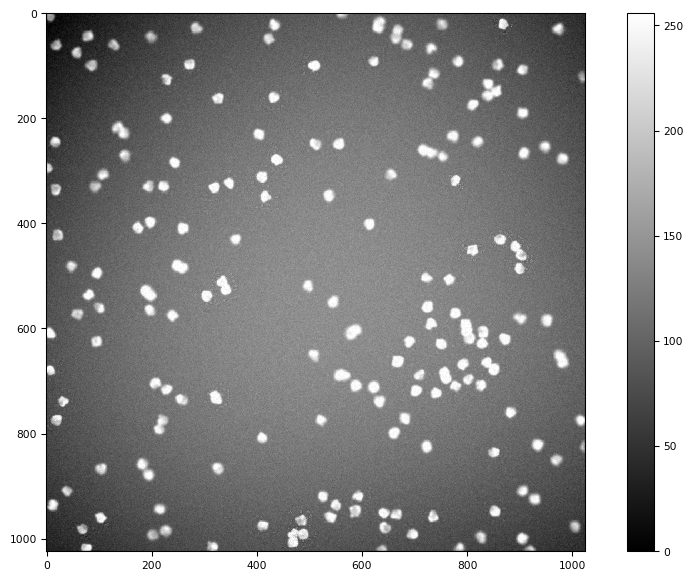

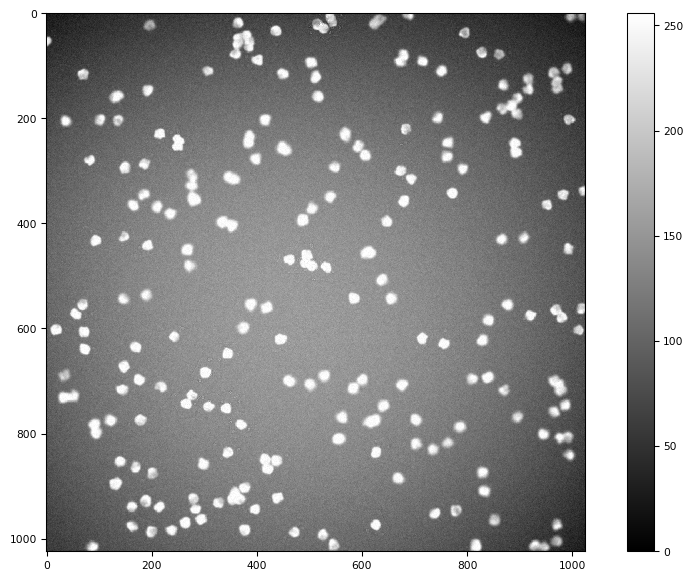

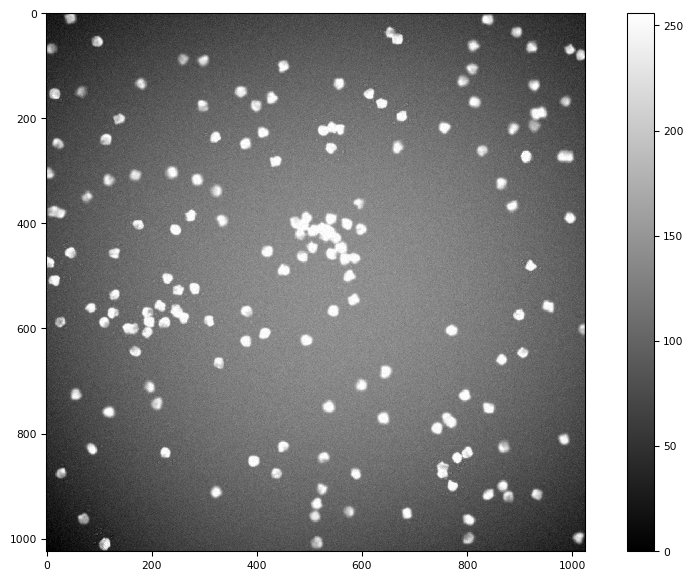

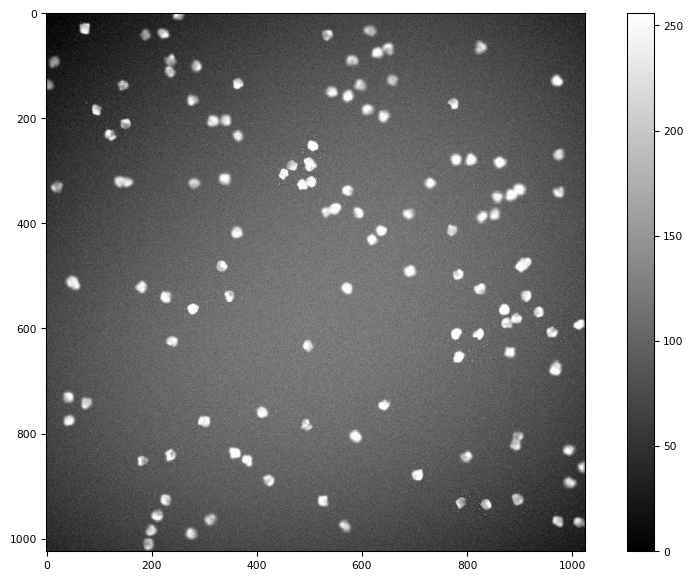

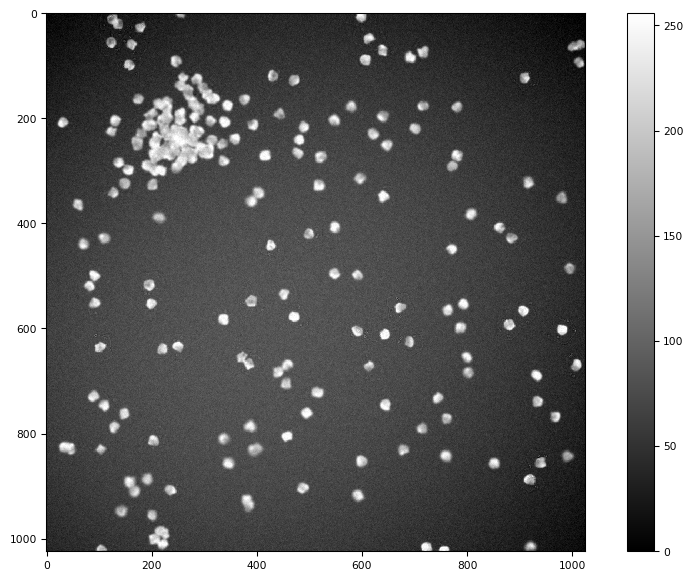

In [6]:
import os
import tifffile
files = [i.path for i in os.scandir(in_path) if i.is_file()]
in_paths_sources = [i for i in files if ('.tif' in i) ]
sources = []
for path in in_paths_sources:
    source = tifffile.imread(path)
    tifffile.imshow(source, cmap='gray')
    sources.append(source)

## Working on the images

In the step of displaying the images they have all been loaded and stored ino the variable ``sources``. The images are loaded as n-dimensional arrays.

We apply a simple example sequence of image processing operations on the first image:
* apply a LoG filter
* find and apply the Otsu-threshold
* apply a watershed-transfomation to separate touching objects

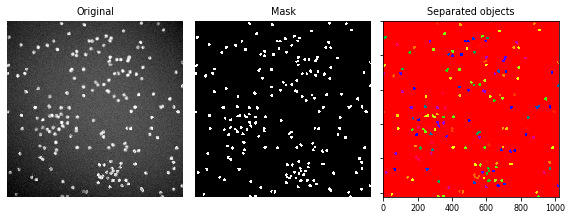

nr of cells:  171


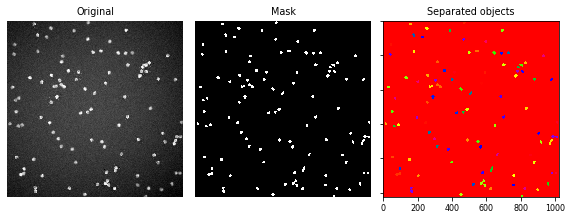

nr of cells:  98


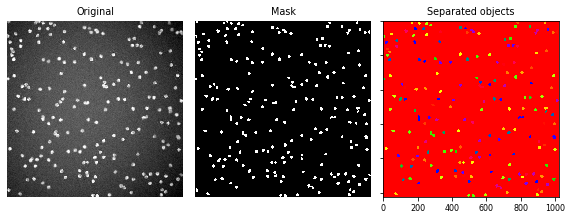

nr of cells:  195


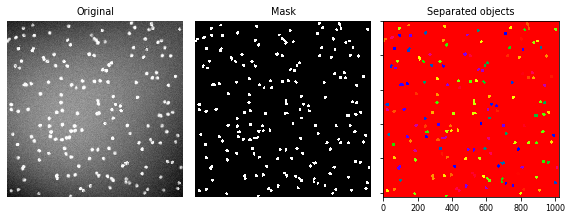

nr of cells:  163


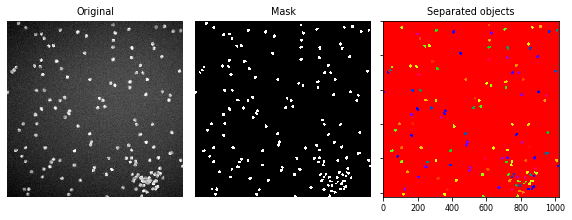

nr of cells:  138


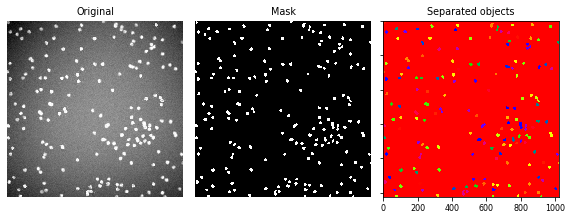

nr of cells:  171


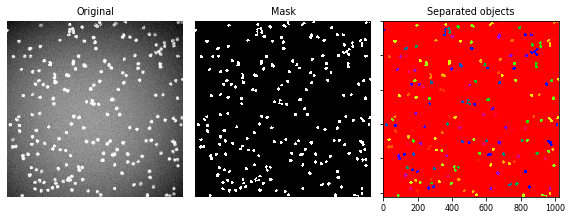

nr of cells:  192


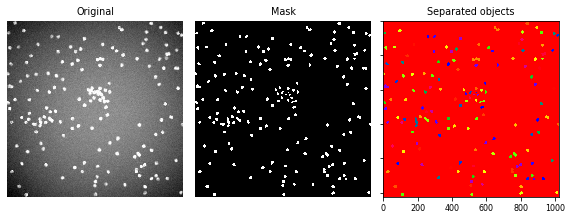

nr of cells:  154


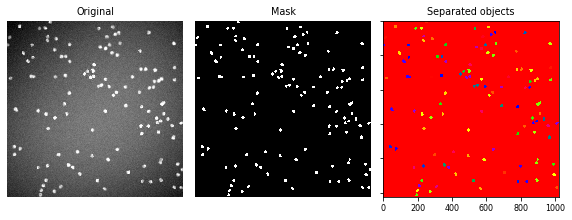

nr of cells:  116


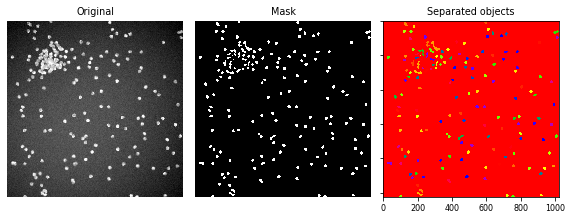

nr of cells:  164


In [28]:
from scipy import ndimage as ndi
from skimage import data, img_as_float, filters
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import matplotlib.pyplot as plt
import numpy as np

counts = []
for image in sources:

    im = img_as_float(image)

    # Apply a LOG filter
    im = ndi.gaussian_laplace(im , 5)

    # find the otsu-threshold and apply it to the filtered image
    val = filters.threshold_otsu(im)
    mask = im<=val

    # Do a watershed on the mask
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((1, 1)),
                                labels=mask)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=mask)

    # display results
    fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('Original')

    ax[1].imshow(mask, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title('Mask')

    ax[2].imshow(labels, cmap=plt.cm.prism)
    ax[2].set_title('Separated objects')

    fig.tight_layout()

    plt.show()
    
    counts.append(np.amax(labels))
    print("nr of cells: ", np.amax(labels))

# Comparison of the results with the ground-truth

The ground-truth is given as indexed masks in which all pixels of one cell have the same value. We can therefore count the number of cells by caclulating the different intensity values in the indexed mask minus 1 for the background value 0.

In [52]:
from pandas import DataFrame
gtFiles = [i.path for i in os.scandir(gt_path) if i.is_file()]
gt_in_paths_sources = [i for i in gtFiles if ('.tif' in i) ]
gt_sources = []
gt_counts = []
for path in gt_in_paths_sources:
    source = tifffile.imread(path)
    gt_counts.append(len(set(source.flatten()))-1)
matrix = [gt_counts, counts]
DataFrame(matrix, ["ground-truth:", "result:"])

0    1    2    3    4    5    6    7    8    9
ground-truth:  192  109  208  187  164  194  233  174  125  227
result:        171   98  195  163  138  171  192  154  116  164

We plot a bar chart to compare the results with the ground-truth.

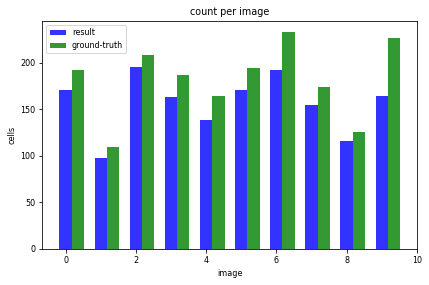

In [32]:
# data to plot
n_groups = len(gt_counts)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, counts, bar_width,
alpha=opacity,
color='b',
label='result')

rects2 = plt.bar(index + bar_width, gt_counts, bar_width,
alpha=opacity,
color='g',
label='ground-truth')

plt.xlabel('image')
plt.ylabel('cells')
plt.title('count per image')
plt.legend()

plt.tight_layout()
plt.show()